In [1]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggsignif))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(reshape2))
options(bitmapType = 'cairo', device = 'png')


setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
tissues_name <- read.table('OUTPUT_GTEx/Tissue_CADgwas', h=F, stringsAsFactors = F)$V1
tissues_name <- tissues_name[!tissues_name %in% c('Artery_Tibial', 'Small_Intestine_Terminal_Ileum', 'Stomach', 'Thyroid')]
geneInfo_file <-  sprintf('OUTPUT_GTEx/train_GTEx/%s/200kb/CAD_GWAS_bin5e-2/resPrior_regEval_allchr.txt', tissues_name)

fold_cl <- 'OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/'
clust_res <- get(load(sprintf('%stscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData', fold_cl)))
outFold <- sprintf('%sCAD_clustering/', fold_notebook)
type_data <- 'tscore'
type_input <- 'zscaled'
type_cluster <- 'Cases'
pheno_name <- 'CAD'
pval_corr_thr <- 0.01
color_tissues <- read.table(sprintf('%scolor_tissues.txt', fold_notebook), h=T, stringsAsFactors = F)

# load tscore and pathway results:
loci_all <- fread(sprintf('%stscore_corrPCs_zscaled_clusterCases_summary_geneLoci_allTissues.txt', fold_cl),
                      h=T, stringsAsFactors = F, data.table = F)
loci_tissues <- fread(sprintf('%stscore_corrPCs_zscaled_clusterCases_summary_geneLoci_tissueSpec.txt', fold_cl), 
                      h=T, stringsAsFactors = F, data.table = F)
pathway_feat <- get(load(sprintf('%spathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_featAssociation.RData', fold_cl)))
tscore_feat <- get(load(sprintf('%stscoreOriginal_corrPCs_tscoreClusterCases_featAssociation.RData', fold_cl)))

In [3]:
#keep_pathways_file <- sprintf("%sfilter_endopheno/Integrated_analysis_v2__final_groupwise_pathways_collapsed_005_v2.txt", fold_cl)
#a = read.delim(keep_pathways_file, h=T, stringsAsFactors = F)
#keep_pathways <- c('endocytosis', 'Golgi Associated Vesicle Biogenesis', 
#                   'positive regulation of T cell proliferation', 
#                   'lipid metabolic process', 'glutathione derivative biosynthetic process', 
#                   'cellular calcium ion homeostasis', 'T cell mediated cytotoxicity', 
#                   'inflammatory response to antigenic stimulus', 
#                   'gamma-delta T cell activation', 
#                   'ABC transporter disorders', 
#                   'fatty acid metabolic process')

keep_pathways <- c('endocytosis', 'Golgi Associated Vesicle Biogenesis', 
                   'positive regulation of T cell proliferation', 
                   'lipid metabolic process', 'glutathione derivative biosynthetic process', 
                   'cellular calcium ion homeostasis', 'T cell mediated cytotoxicity', 
                   'inflammatory response to antigenic stimulus', 
                   'gamma-delta T cell activation', 
                   'ABC transporter disorders', 
                   'fatty acid metabolic process')

In [2]:
#keep_pathways <- c('LDL clearance', 
#    'Metabolism of lipids', 
#    'apolipoprotein binding', 
#    'triglyceride homeostasis',
#    'fatty acid metabolic process', 
#    'triglyceride metabolic process',
#    'ABC-family proteins mediated transport',
#    'Glutathione conjugation', 
#    'Membrane Trafficking', 
#    'Vesicle-mediated transport',  
#    'endocytic vesicle membrane', 
#    'Golgi Associated Vesicle Biogenesis', 
#    'macroautophagy', 
#    'Cytokine Signaling in Immune system',
#    'negative regulation of T cell proliferation', 
#    'type I interferon signaling pathway', 
#    'regulation of immune response')

# A tibble: 11 × 2
   tissue                 feat                                       
   <chr>                  <chr>                                      
 1 Adrenal_Gland          fatty acid metabolic process               
 2 Adrenal_Gland          lipid metabolic process                    
 3 Artery_Aorta           gamma-delta T cell activation              
 4 Artery_Aorta           inflammatory response to antigenic stimulus
 5 Artery_Coronary        T cell mediated cytotoxicity               
 6 Colon_Transverse       positive regulation of T cell proliferation
 7 Heart_Atrial_Appendage cellular calcium ion homeostasis           
 8 Heart_Left_Ventricle   glutathione derivative biosynthetic process
 9 Liver                  ABC transporter disorders                  
10 Liver                  endocytosis                                
11 Liver                  Golgi Associated Vesicle Biogenesis        


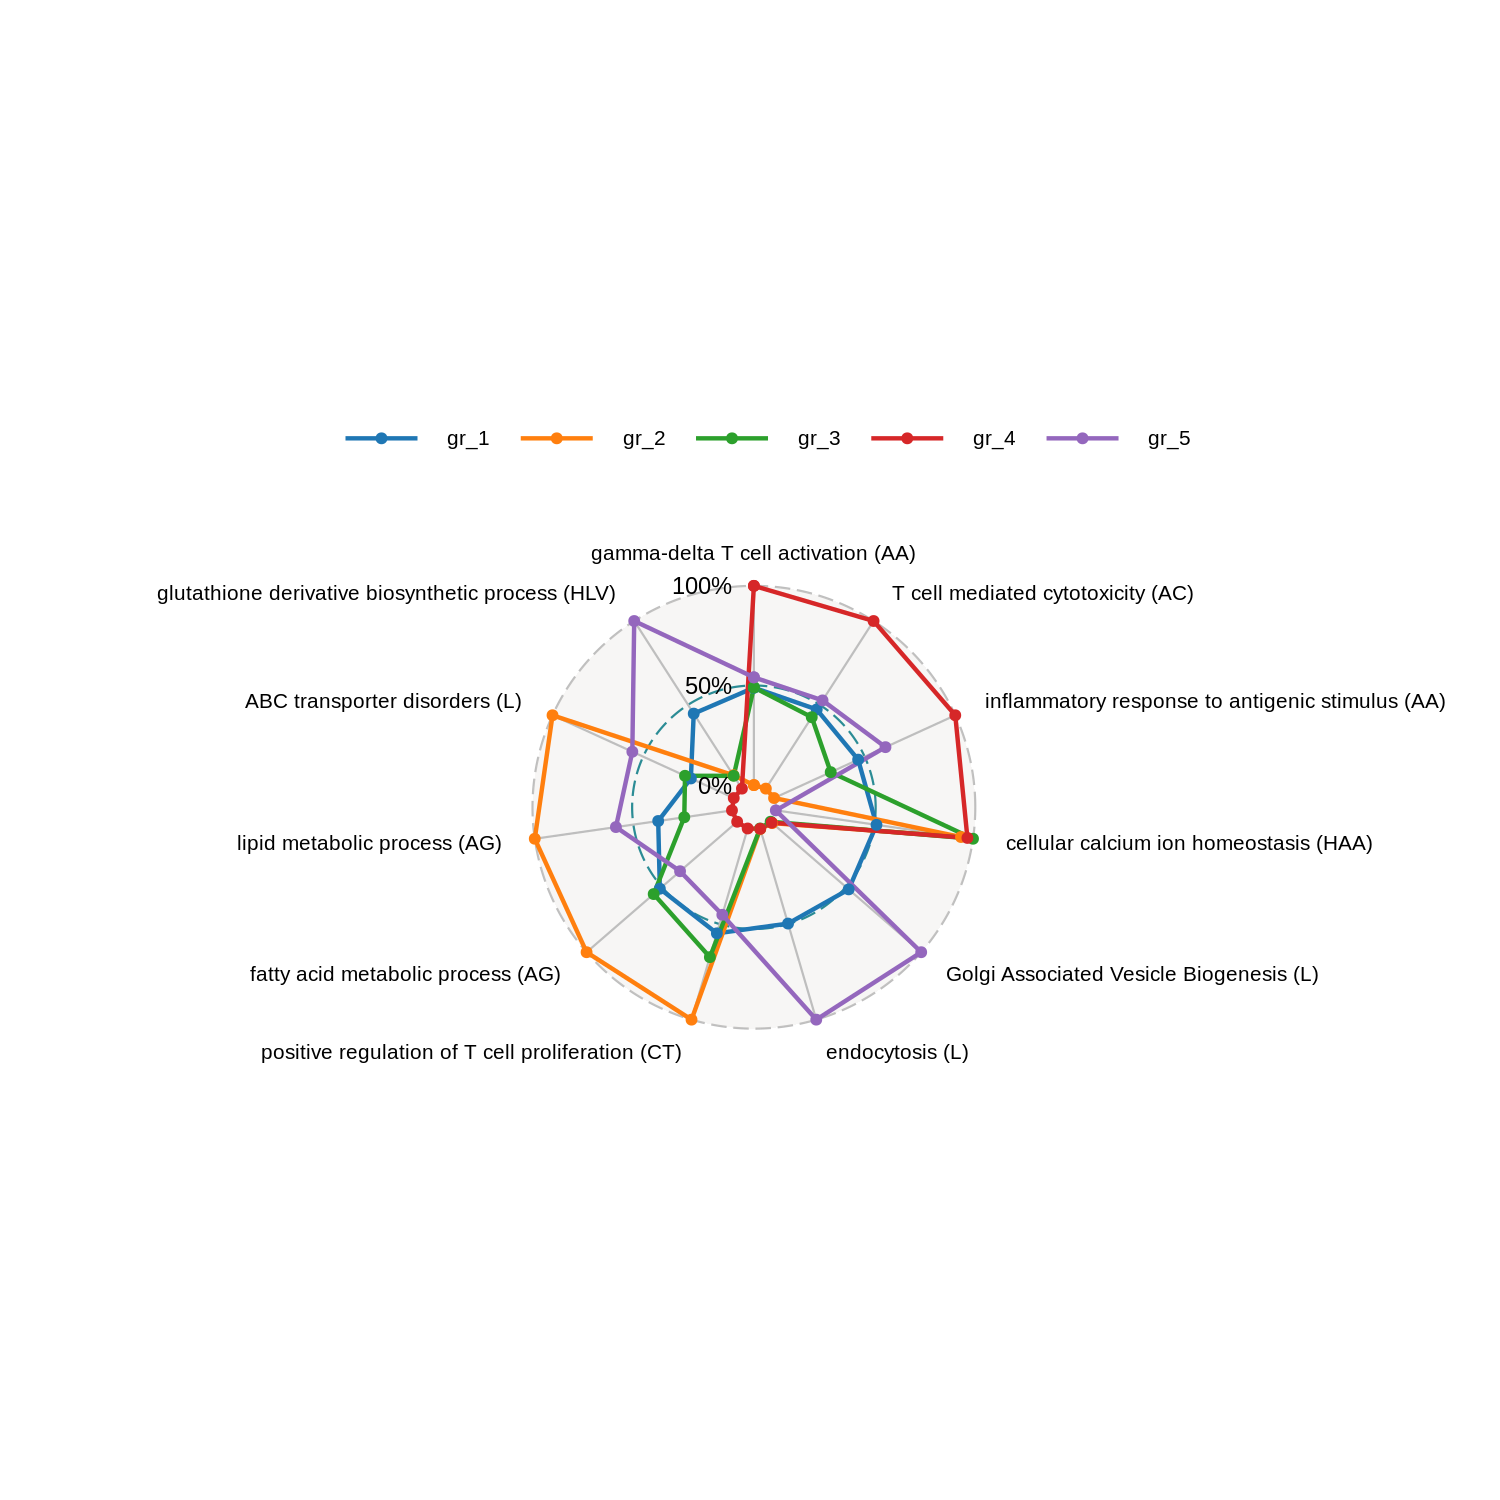

In [5]:
# spider plot for a selection of pathways
get_short_name <- function(tissue_name){
    tmp <- sapply(strsplit(tissue_name, split = '_')[[1]], function(x) 
        substr(x = x, start = 1, stop = 1))
    out <- paste0(tmp, collapse = '')
    out <- paste0('(', out,')')
    return(out)
}

                  
get_pathway_scores <- function(pathway_feat, keep_pathways, res_cl) {
    
    keep_pathways_tissues <- lapply(pathway_feat$test_feat, function(x) 
        x[x$feat %in% keep_pathways & x$pval_corr <= 0.01, ]) %>% 
       dplyr::bind_rows() %>%
       dplyr::group_by(comp, feat) %>%
       dplyr::filter(pval == min(pval)) %>%
       dplyr::arrange(tissue, feat) %>%
       dplyr::ungroup() %>%
       dplyr::select(tissue, feat) %>%
       dplyr::distinct()
    print(keep_pathways_tissues)
                                
    # get pathway-scores
    pathscore <- list()
    for(i in 1:nrow(keep_pathways_tissues)){
    
        idx_t <- which(pathway_feat$tissues == keep_pathways_tissues$tissue[i])
        id_path <- keep_pathways_tissues$feat[i]
        tmp <- pathway_feat$scaleData[[idx_t]][, id_path, drop = F]
        colnames(tmp) <- paste(colnames(tmp), get_short_name(keep_pathways_tissues$tissue[i]))
        pathscore[[i]] <- tmp
    }            
    pathscore <- do.call(cbind, pathscore)
    
    gr_id <- sort(unique(res_cl$gr))
    df_mean <- t(sapply(gr_id, function(x) colMeans(pathscore[res_cl$gr == x,], na.rm = T)))
    df_mean <- cbind(data.frame(group = paste0('gr_',gr_id)), df_mean)
    df_mean[, -1] <- apply(df_mean[,-1], 2, rescale)
                                    
    return(list(mean = df_mean, pathways = keep_pathways_tissues))
}
                                    
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 150)

library(scales)
library(ggradar)
                                                
res_cl <- pathway_feat$cl                                  
input_spider <- get_pathway_scores(pathway_feat, keep_pathways, res_cl)
df_mean <- input_spider$mean
keep_pathways_tissues <- input_spider$pathways
gr_color <- pal_d3(palette = 'category20')(length(unique(res_cl$gr)))
df_mean <- df_mean[, order(df_mean[1,], decreasing = T)]
df_mean <- df_mean[, order(df_mean[2,], decreasing = T)]      
df_mean <- df_mean[, order(df_mean[4,], decreasing = T)]                              
                        
pl <- ggradar(df_mean,  grid.min = 0, grid.max = 1, grid.mid = 0.5, 
              values.radar = c('0%', '50%', '100%'),
              group.colours = gr_color, 
              grid.label.size = 5,
              axis.label.size = 3.5, 
              group.point.size = 2,
              group.line.width = 1,
              legend.text.size= 10, 
              legend.position = 'top', 
              plot.extent.x.sf = 2, 
              plot.extent.y.sf = 1.2)
pl                    

ggsave(plot = pl, filename = sprintf('%scl%s_spiderPlotPhatway_tscoreClusterCases.pdf',  outFold, 'Liver'), 
       device = 'pdf', width = 10, height = 10)


                                                

In [19]:
# heatmap plot selected pathways and significant endophophenotype
phenotype_sign <- read.table(sprintf("%sfilter_endopheno/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric_phenoAssociation_GLM_combined_keepPhenoClass.txt", fold_cl),
                             header = T, stringsAsFactors = F, sep = '\t') %>%
                filter(pval_corr <= 0.1)
tissues_to_load <- unique(keep_pathways_tissues$tissue)
pheno_type <- setdiff(unique(phenotype_sign$pheno_type), "Height_derived")

df_res_t_p <- list()

for(i in 1:length(pheno_type)){
    
    print(pheno_type[i])
    df_res_t <- list()
    
for(j in 1:length(tissues_to_load)){

    print(tissues_to_load[j])
    if(pheno_type[i] == 'ICD9-10_OPCS4'){
        pheno_type_name <- "ICD10_Endocrine"
    }else{
        pheno_type_name <-  pheno_type[i]
    }
    file_PALAS <- sprintf("OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/pval_%s_withMed_pheno_covCorr.RData", 
                          tissues_to_load[j], pheno_type_name)

    if(!file.exists(file_PALAS)){
        file_PALAS <- sprintf("OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/pval_%s_pheno_covCorr.RData", 
                              tissues_to_load[j], pheno_type_name)
    }

    res_pval <- get(load(file_PALAS))

    pathways_to_keep <-  keep_pathways_tissues$feat[keep_pathways_tissues$tissue == tissues_to_load[j]]

    id_pheno_to_keep <- which(res_pval$pheno$pheno_id %in% phenotype_sign$pheno_id)

    df_res <- list()
    for(k in 1:length(id_pheno_to_keep)){
    
        idx <- id_pheno_to_keep[k]
        tmp1 <- res_pval$pathScore_reactome[[idx]][res_pval$pathScore_reactome[[idx]]$path %in% pathways_to_keep,]
        tmp2 <- res_pval$pathScore_GO[[idx]][res_pval$pathScore_GO[[idx]]$path %in% pathways_to_keep,]

       
        if(nrow(tmp1) > 0 & nrow(tmp2) > 0){
            tmp2 <- tmp2[, !colnames(tmp2) %in% c("path_id", "path_ont")]
            tmp <- rbind(tmp1, tmp2)
        }else{
            if(nrow(tmp1) == 0){tmp <- tmp2}
            if(nrow(tmp2) == 0){tmp <- tmp1}
        }

        df_res[[k]] <- tmp %>% 
            dplyr::select(path, ngenes_tscore, ngenes_path, 
                      dplyr::ends_with("_pval"),
                       dplyr::ends_with("_z_t"), 
                       dplyr::ends_with("_BHcorr")) %>%
            dplyr::mutate(pheno_name = res_pval$pheno$pheno_id[idx], 
                  Field =  res_pval$pheno$Field[idx], 
                  meaning = res_pval$pheno$Coding_meaning[idx],
                  pheno_class = pheno_type[i], 
                  tissue = tissues_to_load[j])

        colnames(df_res[[k]]) <- c("path", "ngenes_tscore", "ngenes_path", "pval", "z_t",
                              "BHcorr","pheno_name", "Field", "meaning","pheno_type", "tissue")    
    
    }
    df_res_t[[j]] <- do.call(rbind, df_res)

}
df_res_t_p[[i]] <- do.call(rbind, df_res_t)
    
}

PALAS_res_subset <- do.call(rbind, df_res_t_p)



[1] "Blood_biochemistry"
[1] "Adrenal_Gland"
[1] "Artery_Aorta"
[1] "Artery_Coronary"
[1] "Colon_Transverse"
[1] "Heart_Atrial_Appendage"
[1] "Heart_Left_Ventricle"
[1] "Liver"
[1] "Blood_count"
[1] "Adrenal_Gland"
[1] "Artery_Aorta"
[1] "Artery_Coronary"
[1] "Colon_Transverse"
[1] "Heart_Atrial_Appendage"
[1] "Heart_Left_Ventricle"
[1] "Liver"
[1] "ICD9-10_OPCS4"
[1] "Adrenal_Gland"
[1] "Artery_Aorta"
[1] "Artery_Coronary"
[1] "Colon_Transverse"
[1] "Heart_Atrial_Appendage"
[1] "Heart_Left_Ventricle"
[1] "Liver"
[1] "Family_history"
[1] "Adrenal_Gland"
[1] "Artery_Aorta"
[1] "Artery_Coronary"
[1] "Colon_Transverse"
[1] "Heart_Atrial_Appendage"
[1] "Heart_Left_Ventricle"
[1] "Liver"


In [40]:

PALAS_res_subset <- PALAS_res_subset %>%
    dplyr::rowwise() %>%
    dplyr::mutate(path_tissue = paste(path, get_short_name(tissue))) %>%
    ungroup()

PALAS_res_subset$pheno_name_plot <- paste(PALAS_res_subset$Field, PALAS_res_subset$meaning, sep = '\n')
PALAS_res_subset$pheno_name_plot[is.na(PALAS_res_subset$meaning)] <- PALAS_res_subset$Field[is.na(PALAS_res_subset$meaning)]
PALAS_res_subset$pheno_name_plot[grepl("Diagnoses", PALAS_res_subset$Field) & !is.na(PALAS_res_subset$meaning)] <- PALAS_res_subset$meaning[grepl("Diagnoses", PALAS_res_subset$Field) & !is.na(PALAS_res_subset$meaning)]
PALAS_res_subset$pheno_name_plot[grepl("Illnesses", PALAS_res_subset$Field) & !is.na(PALAS_res_subset$meaning)] <- paste(PALAS_res_subset$Field[grepl("Illnesses", PALAS_res_subset$Field) & !is.na(PALAS_res_subset$meaning)], PALAS_res_subset$meaning[grepl("Illnesses", PALAS_res_subset$Field) & !is.na(PALAS_res_subset$meaning)], sep = ': ')


PALAS_matrix <- dcast(data = PALAS_res_subset, 
                      formula = pheno_name_plot ~ path_tissue, 
                      value.var = "z_t")
rownames(PALAS_matrix) <- PALAS_matrix[,1]
PALAS_matrix <- PALAS_matrix[, -1]

PALAS_matrix_fdr <- dcast(data = PALAS_res_subset, 
                          formula = pheno_name_plot ~ path_tissue, 
                          value.var = "BHcorr")
rownames(PALAS_matrix_fdr) <- PALAS_matrix_fdr[,1]
PALAS_matrix_fdr <- PALAS_matrix_fdr[, -1]
PALAS_matrix_fdr <- PALAS_matrix_fdr <= 0.05




png 
  2

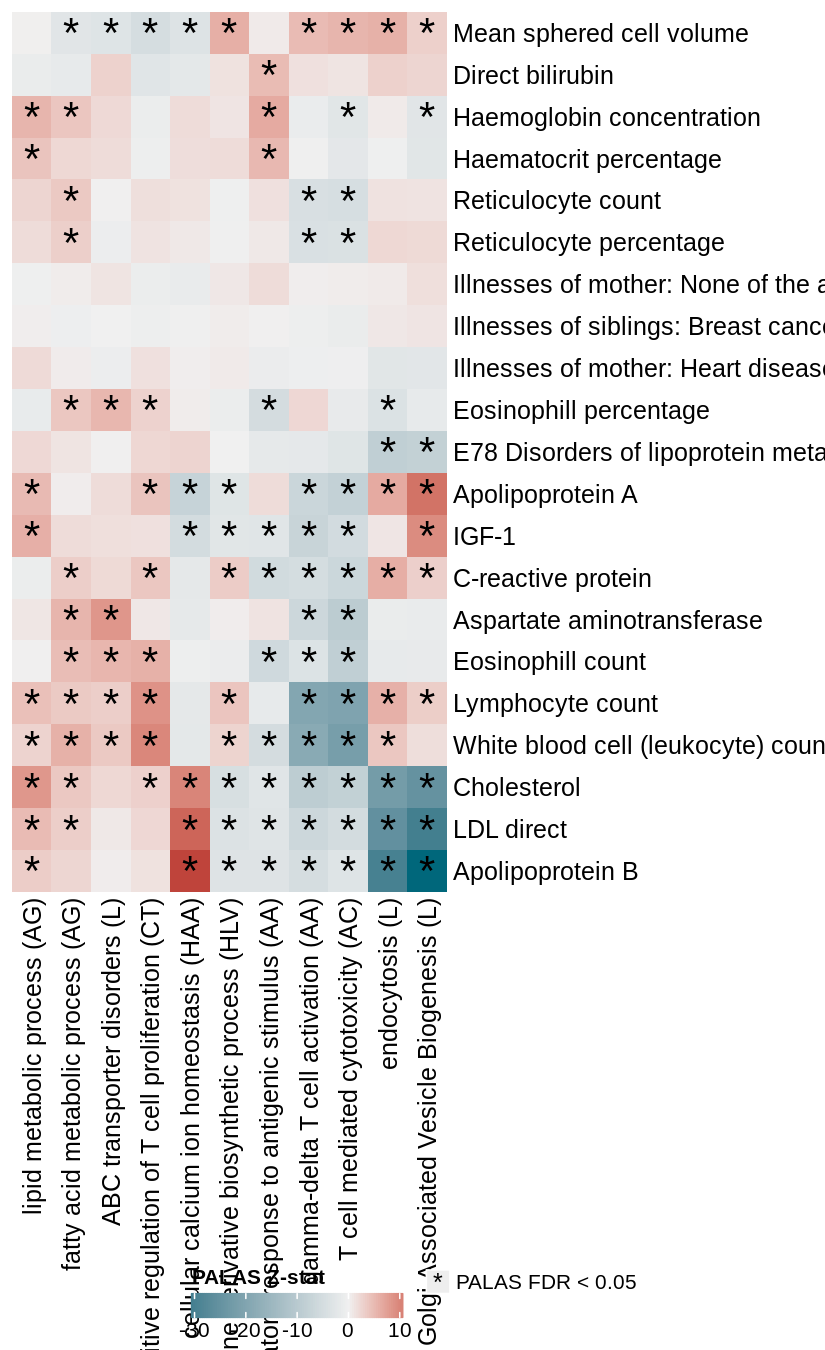

In [41]:

options(repr.plot.width = 5.5, repr.plot.height = 9, repr.plot.res = 150)

tmp_mat <- as.matrix(PALAS_matrix)

# legend
estimate_col_fun = colorRamp2(c(min(tmp_mat), 0, max(tmp_mat)), 
                              c("#00677B", "#F0F0F0", "#BF443B"))

lgd_est <- Legend(title = "PALAS Z-stat", 
                  col = estimate_col_fun, 
                 direction = "horizontal")
# fdr
lgd_sig <- Legend(pch = "*", type = "points", 
                  labels = sprintf("PALAS FDR < %s", as.character(0.05)))
PALAS_matrix_fdr_pch <- PALAS_matrix_fdr
PALAS_matrix_fdr_pch[PALAS_matrix_fdr] <- '*'
PALAS_matrix_fdr_pch[!PALAS_matrix_fdr] <- ''

hm_pl <- Heatmap(tmp_mat,
                 show_row_dend = FALSE, 
                 show_column_dend = FALSE,
                 col = estimate_col_fun, 
                 show_heatmap_legend = FALSE, 
                 cell_fun = function(j, i, x, y, width, height, fill){
                            grid.text(sprintf("%s", PALAS_matrix_fdr_pch[i, j]), 
                                    x, y, gp = gpar(fontsize = 20))})

pdf(sprintf('%scl%s_heatmapZstat_pathVSpheno_tscoreClusterCases.pdf',  outFold, 'Liver'), 
    width = 5.5, height = 9)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig), 
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
dev.off()

draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig), 
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")


In [10]:
### functions ###
create_df_genes <- function(alltissues_loci, tissue_spec_loci, gr_tot){
    
   df <- data.frame(ngenes = c(), tissue = c(), comp = c(), loci = c())
    tissues <- unique(tissue_spec_loci$tissue)
    
    for(i in 1:length(gr_tot)){
      tmp <- alltissues_loci[grepl(gr_tot[i], alltissues_loci$comp_sign),]
      df <- rbind(df, data.frame(ngenes = tmp$ngenes_unique, 
                                 tissue = rep('All', nrow(tmp)), 
                                 comp = rep(gr_tot[i], nrow(tmp)), 
                                 loci = tmp$loci_id))
    }

    for(j in 1:length(tissues)){
      for(i in 1:length(gr_tot)){
        tmp <- tissue_spec_loci[grepl(gr_tot[i], tissue_spec_loci$comp_sign) & tissue_spec_loci$tissue %in% tissues[j],]
        df <- rbind(df, data.frame(ngenes = tmp$ngenes, 
                                   tissue = rep(tissues[j], nrow(tmp)), 
                                   comp = rep(gr_tot[i], nrow(tmp)), loci = tmp$loci_id))
      }
    }

    df$comp <- factor(df$comp, levels = unname(gr_tot))
    df$tissue <- factor(df$tissue, levels = c('All', tissues))
    # newcolours <- c('grey', color_tissues$color[match(tissues, color_tissues$tissues)])
    # put loci in id based on overall comparison
    df$loci_name <- df$loci
    id_notall <- which(df$tissue !='All')
    for(i in id_notall){
      tmp <- tissue_spec_loci[tissue_spec_loci$loci_id == df$loci[i] & grepl(df$comp[i], tissue_spec_loci$comp_sign) & tissue_spec_loci$tissue == df$tissue[i] ,]
      tmp_all <- alltissues_loci[alltissues_loci$chrom == tmp$chrom,]
      tmp_all <- tmp_all[which.min(abs(tmp_all$start - tmp$start)),]
      df$loci_name[i] <- tmp_all$loci_id
    }
    df$loci_name <- factor(df$loci_name, levels =unique( alltissues_loci$loci_id))

    # same plot but n. of loci and not genes
    df_loci <- data.frame(tissue = unlist(lapply(c('All', tissues), function(x) rep(x, length(gr_tot)))), comp = rep(gr_tot, length(tissues)+1), 
                          nloci = as.vector(table(df$comp, df$tissue)))
    df_loci$comp <- factor(df_loci$comp, levels = unname(gr_tot))
    df_loci$tissue <- factor(df_loci$tissue, levels = c('All', tissues))
                                          
    df$comp <- factor(df$comp, levels = unname(gr_tot))
    df$tissue <- factor(df$tissue, levels = c('All', tissues))
    # newcolours <- c('grey', color_tissues$color[match(tissues, color_tissues$tissues)])
    # put loci in id based on overall comparison
    df$loci_name <- df$loci
    id_notall <- which(df$tissue !='All')
    for(i in id_notall){
      tmp <- tissue_spec_loci[tissue_spec_loci$loci_id == df$loci[i] & grepl(df$comp[i], tissue_spec_loci$comp_sign) & tissue_spec_loci$tissue == df$tissue[i] ,]
      tmp_all <- alltissues_loci[alltissues_loci$chrom == tmp$chrom,]
      tmp_all <- tmp_all[which.min(abs(tmp_all$start - tmp$start)),]
      df$loci_name[i] <- tmp_all$loci_id
    }
    df$loci_name <- factor(df$loci_name, levels =unique( alltissues_loci$loci_id))

    # same plot but n. of loci and not genes
    df_loci <- data.frame(tissue = unlist(lapply(c('All', tissues), function(x) rep(x, length(gr_tot)))), comp = rep(gr_tot, length(tissues)+1), 
                          nloci = as.vector(table(df$comp, df$tissue)))
    df_loci$comp <- factor(df_loci$comp, levels = unname(gr_tot))
    df_loci$tissue <- factor(df_loci$tissue, levels = c('All', tissues))
                                          
    return(list(df = df, count_loci = df_loci))
}


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


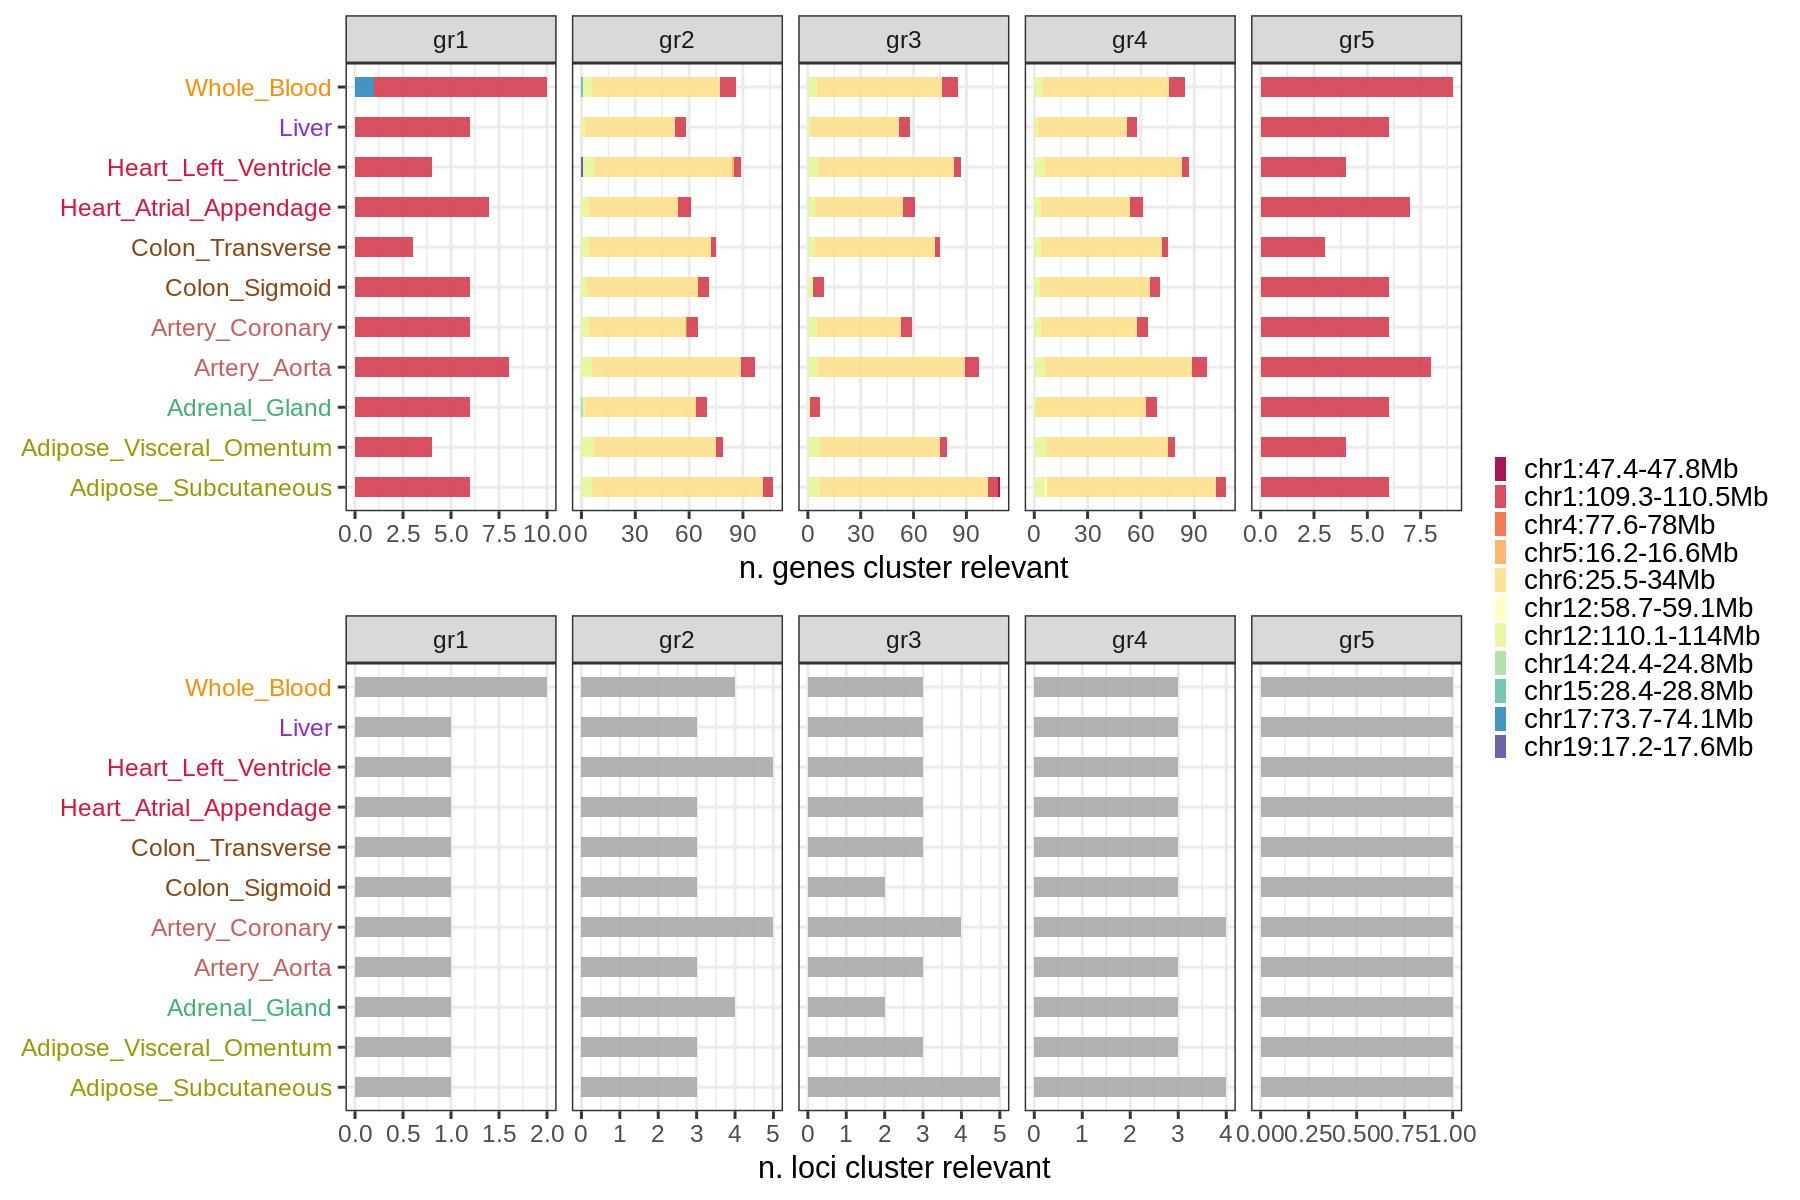

In [13]:
#### plot count (across tissues) ####
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 200)

gr_tot <- paste0('gr', sort(unique(clust_res$cl_best$gr)))
out <- create_df_genes(alltissues_loci = loci_all, loci_tissues, gr_tot = gr_tot)
df <- out$df
df_loci <- out$count_loci
newcolours <- c('grey', color_tissues$color[match(tissues_name, color_tissues$tissues)])

coul <- colorRampPalette(brewer.pal(11, "Spectral"))(length(levels(df$loci_name)))
color_gr <- pal_d3("category10")(length(gr_tot))

pl1 <- ggplot(data = subset(df, tissue != 'All'), aes(x = tissue, y = ngenes, fill = loci_name))+
  geom_bar(alpha = 0.9, width = 0.5, stat = 'identity')+
  facet_wrap(.~comp, ncol = length(gr_tot), scales = 'free_x')+
  ylab('n. genes cluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'right', legend.key.size = unit(0.2, "cm"), 
        legend.text = element_text(size = 10), legend.title = element_blank(), 
        axis.title.y = element_blank(), axis.text.y = element_text(colour = newcolours[-1]))+
  guides(fill=guide_legend(ncol=1))+
  scale_fill_manual(values = coul)+
  coord_flip() 

pl2 <- ggplot(data = subset(df_loci, tissue != 'All'), aes(x = tissue, y = nloci))+
  geom_bar(alpha = 0.9, width = 0.5, stat = 'identity', fill = 'darkgrey')+
  facet_wrap(.~comp, ncol = length(gr_tot), scales = 'free_x')+
  ylab('n. loci cluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'right', legend.key.size = unit(0.5, "cm"), 
        legend.text = element_text(size = 10), legend.title = element_blank(), 
        axis.title.y = element_blank(), axis.text.y = element_text(colour = newcolours[-1]))+
  coord_flip() 

tot_pl <- ggarrange(plotlist = list(pl1, pl2), ncol=1, nrow=2, 
                    align = 'v', common.legend = T,
                    legend = 'right')
tot_pl
ggsave(filename = sprintf('%scluster_ngenes_nloci_pertissues_%s_%s.pdf', outFold, type_data, type_input),
       plot = tot_pl, width = 9, height = 6, dpi = 200)


 
  


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


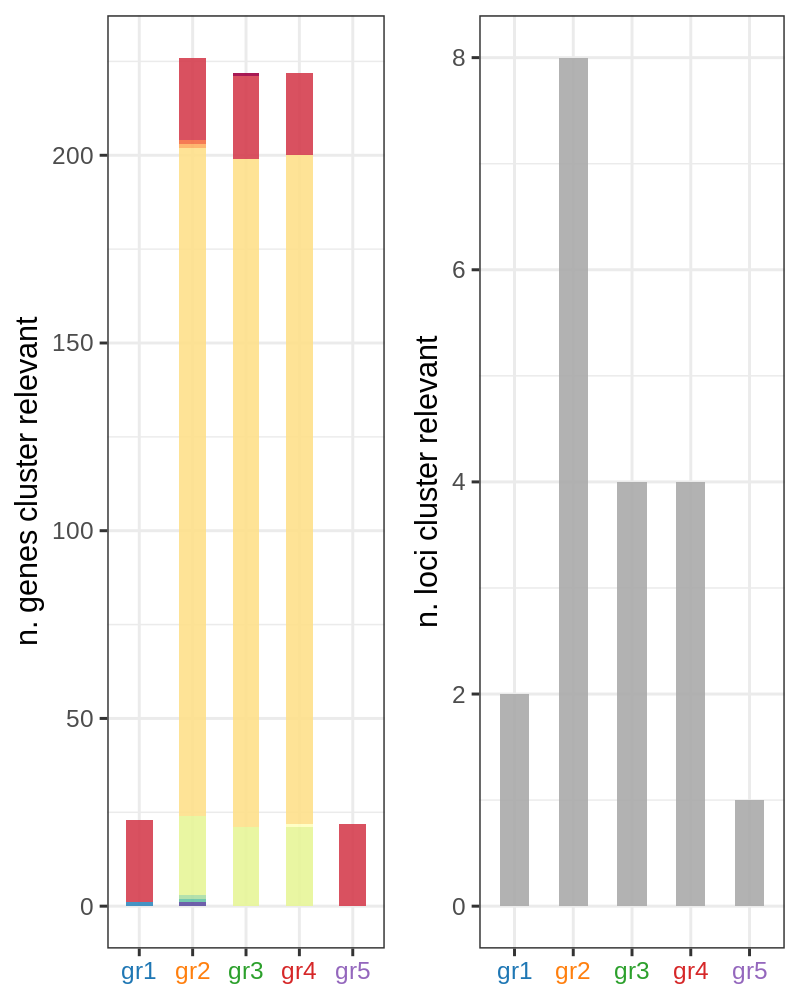

In [14]:
#### plot count (combined tissues) ####
options(repr.plot.width = 4, repr.plot.height = 5, repr.plot.res = 200)

pl1 <- ggplot(data = subset(df, tissue == 'All'), aes(x = comp, y = ngenes, fill = loci_name))+
  geom_bar(alpha = 0.9, width = 0.5, stat = 'identity')+
  ylab('n. genes cluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'none', legend.key.size = unit(0.2, "cm"), plot.title = element_text(hjust = 0.5),
        legend.text = element_text(size = 10), legend.title = element_blank(), 
        axis.title.x = element_blank(), axis.text.x = element_text(colour = color_gr))+
  scale_fill_manual(values = coul)+
  guides(fill=guide_legend(ncol=1))

pl2 <- ggplot(data = subset(df_loci, tissue == 'All'), aes(x = comp, y = nloci))+
  geom_bar(alpha = 0.9, width = 0.5, stat = 'identity', fill = 'darkgrey')+
  # facet_wrap(.~comp, ncol = length(gr_tot), scales = 'free_x')+
  ylab('n. loci cluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'none', legend.key.size = unit(0.5, "cm"), 
        legend.text = element_text(size = 10), legend.title = element_blank(), 
        axis.title.x = element_blank(), axis.text.x = element_text(colour = color_gr))+
  scale_fill_d3()

tot_pl <- ggarrange(plotlist = list(pl1, pl2), ncol=2, nrow=1, align = 'h')
ggsave(filename = sprintf('%scluster_ngenes_nloci_alltissues_%s_%s.pdf', outFold, type_data, type_input), 
       plot = tot_pl, width = 4, height = 5, dpi = 200)
tot_pl


In [15]:
### function for heatmap plot (genes)
get_short_name <- function(tissue_name){
    tmp <- sapply(strsplit(tissue_name, split = '_')[[1]], function(x) 
        substr(x = x, start = 1, stop = 1))
    out <- paste0(tmp, collapse = '')
    out <- paste0('(', out,')')
    return(out)
}

df_match <- data.frame(tissue = tissues_name, 
                       short = sapply(tissues_name, function(x) get_short_name(x)))

tscore_tot <- do.call(rbind, tscore_feat$test_feat) 
tscore_tot <- left_join(tscore_tot, df_match) %>%
    mutate(new_id = paste(feat, short)) 
tscore_sign <- tscore_tot %>% filter(pval_corr <= pval_corr_thr)

# combine res_pval:                                      
res_pval_tot <- do.call(rbind, tscore_feat$res_pval) 
res_pval_tot <- left_join(res_pval_tot, df_match) %>%
    mutate(new_id = paste(external_gene_name, short)) 
                                      
length(unique(tscore_sign$new_id))
length(unique(tscore_sign$feat))
nrow(loci_tissues)
nrow(loci_all)

table(tscore_tot$comp)                                      

Joining, by = "tissue"

Joining, by = "tissue"



[1] 863

[1] 229

[1] 44

[1] 11


gr1_vs_all gr2_vs_all gr3_vs_all gr4_vs_all gr5_vs_all 
     36397      36397      36397      36397      36397 

- 36397 genes tested across all tissues (with replication)
- 863 significant genes, 229 unique across all tissues. 
- combined into 44 loci in 11 tissues and 11 combined across tissues

In [16]:
# get the most significant gene per locus and create matrix
feat_est <- matrix(NA, nrow = nrow(loci_all), ncol = length(gr_tot))
feat_CIl <- matrix(NA, nrow = nrow(loci_all), ncol = length(gr_tot))
feat_CIu <- matrix(NA, nrow = nrow(loci_all), ncol = length(gr_tot))
feat_pvcorr <- matrix(NA, nrow = nrow(loci_all), ncol = length(gr_tot))
gene_names <- vector(mode = 'numeric', length = nrow(loci_all))

for(i in 1:nrow(feat_est)){
# i=10
loci_tmp <- loci_all[i,]
genes <- strsplit(loci_tmp$gene, split = ',')[[1]]
tmp <- tscore_sign %>% filter(feat %in% genes)
n_gr <- length(unique(tmp$comp))
# consider genes that are singificant in highest number of groups possible
genes_common <- names(which(table(tmp$new_id) == n_gr))
tmp <- tmp %>% filter(new_id %in% genes_common)
top_gene <- tmp[order(tmp$pval), ]
top_gene <- top_gene[order(abs(top_gene$estimate), decreasing = T), ]
top_gene <- top_gene$new_id[1]

feat_est[i,] <- tscore_tot$estimates[tscore_tot$new_id == top_gene]
feat_CIl[i,] <- tscore_tot$CI_up[tscore_tot$new_id == top_gene]
feat_CIu[i,] <- tscore_tot$CI_up[tscore_tot$new_id == top_gene]
feat_pvcorr[i,] <- tscore_tot$pval_corr[tscore_tot$new_id == top_gene]

gene_names[i] <- top_gene
}

rownames(feat_est) <- rownames(feat_CIl) <- rownames(feat_CIu) <- rownames(feat_pvcorr) <- gene_names
colnames(feat_est) <- colnames(feat_CIl) <- colnames(feat_CIu) <- colnames(feat_pvcorr) <- gr_tot
res_pval_est <- res_pval_tot[match(gene_names, res_pval_tot$new_id), ]

png 
  2

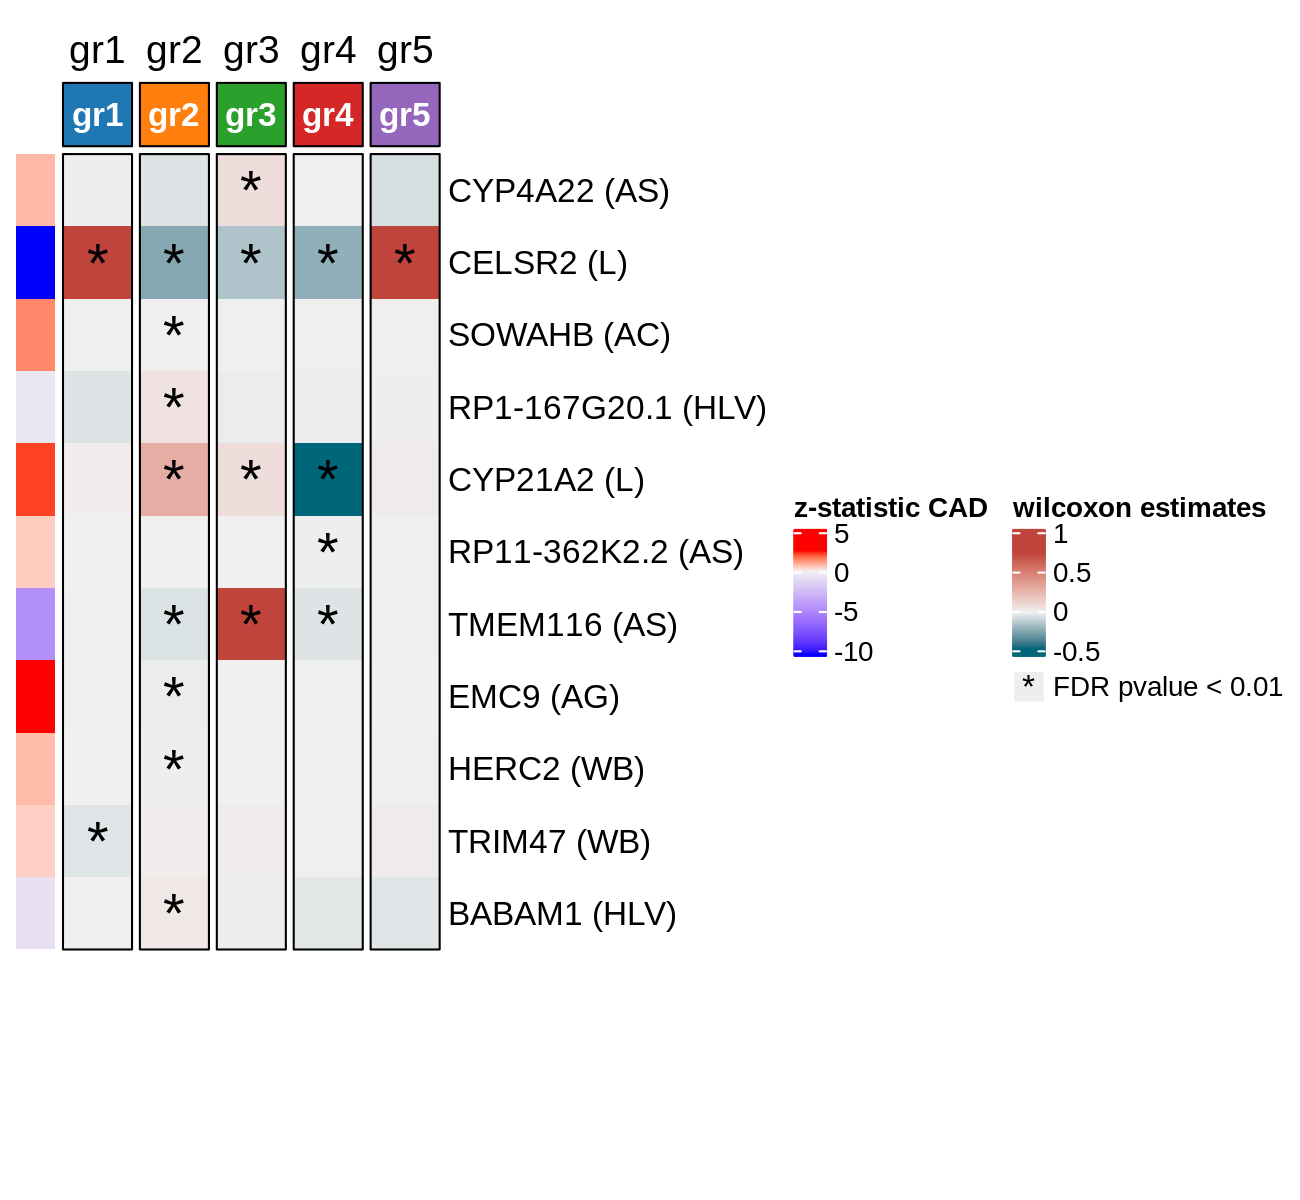

In [17]:
options(repr.plot.width = 6.5, repr.plot.height = 6, repr.plot.res = 200)
pheno_name <- 'CAD'

P <- length(gr_tot)
# cap
tmp_mat <- as.matrix(feat_est)
val <- abs(quantile(as.vector(feat_est),probs = 0.95))
mat_breaks <- seq(-val, val, length.out = 100)
tmp_mat[tmp_mat>=val] <- val
tmp_mat[tmp_mat<=-val] <- -val

mat_colors_gr <- list(cluster = pal_d3(palette = 'category20')(P))
names(mat_colors_gr$cluster) <- gr_tot

column_ha <- HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = mat_colors_gr$cluster),
                                                    labels = names(mat_colors_gr$cluster),
                                                    labels_gp = gpar(col = "white", fontsize = 12,  
                                                                     fontface = "bold")))
feat_pvcorr_pch <- feat_pvcorr
feat_pvcorr_pch[feat_pvcorr <= pval_corr_thr] <- '*'
feat_pvcorr_pch[feat_pvcorr > pval_corr_thr] <- ''

estimate_col_fun = colorRamp2(c(min(tmp_mat), 0, max(tmp_mat)), 
                                c("#00677B", "#F0F0F0", "#BF443B"))
zstat_col_fun = colorRamp2(c(min(res_pval_est[,7]), 0, max(res_pval_est[,7])), 
                             c("blue","#F0F0F0", "red"))

row_ha <- rowAnnotation(zstat = res_pval_est[,7],
                        col = list(zstat = zstat_col_fun), 
                        annotation_label = list(zstat = sprintf('z-statistic %s', pheno_name)), 
                        annotation_name_gp = gpar(col = 'white'))

lgd_est <- Legend(title = "wilcoxon estimates", col = estimate_col_fun)
lgd_sig = Legend(pch = "*", type = "points", labels = sprintf("FDR pvalue < %s", as.character(pval_corr_thr)))

hm_pl <- Heatmap(tmp_mat, top_annotation = column_ha, 
                 left_annotation = row_ha,  
                 column_split = gr_tot, 
                 cluster_rows = F, cluster_columns = F, show_column_names = F, 
                 col = estimate_col_fun, border = TRUE, show_heatmap_legend = F, 
                 cell_fun = function(j, i, x, y, width, height, fill){
                           grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y, gp = gpar(fontsize = 20))})

pdf(sprintf('%sheatmap_cluster_genes_WMWest_%s_%s.pdf', outFold, type_data, type_input), width= 6.5, height = 6)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig))
dev.off() 
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig))


[1]  0.00e+00  0.00e+00  0.00e+00 1.02e-265 6.73e-265  0.00e+00  0.00e+00
 [8]  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00 3.52e-283 8.51e-283
[15] 2.56e-272  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00
[22]  0.00e+00  0.00e+00 1.12e-120 3.20e-112

feat,max_gr
<chr>,<dbl>
HLA-DRB6,4.488592
ATXN7L2,5.745189
SYPL2,8.012334
HLA-DQA2,9.394663
XXbac-BPG299F13.17,11.067593
CYP21A1P,12.627553
PSORS1C1,15.439245
XXbac-BPG248L24.12,16.535565
HLA-C,18.759667


feat,max_gr
<chr>,<dbl>
PC4,0.7908617
PC5,0.7915685


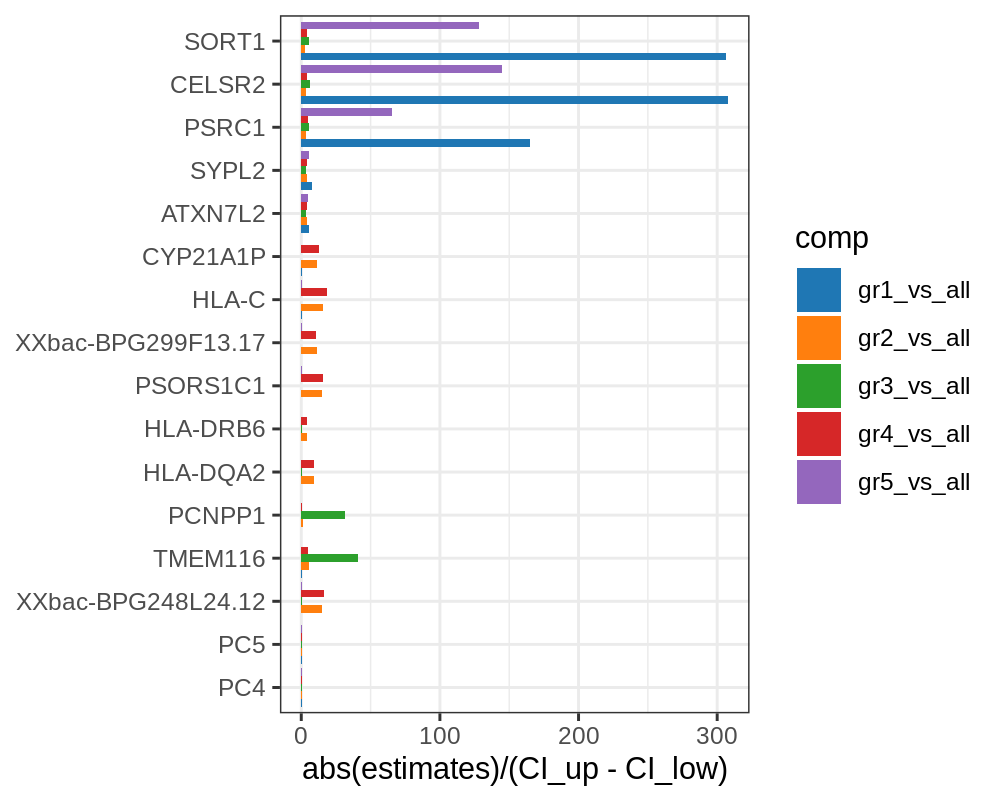

In [21]:
options(repr.plot.width = 5, repr.plot.height = 4, repr.plot.res = 200)

gr_color <- pal_d3(palette = 'category20')(length(unique(tscore_tot$comp)))
# compare effect size covariates and genes:
feat_sign <- tscore_tot %>% 
    dplyr::filter(pval_corr <= 0.01, tissue == "Liver") %>%
    dplyr::arrange(pval, estimates) %>%
    dplyr::group_by(comp) %>%
    dplyr::slice_head(n=5)
feat_sign$pval


df_feat_plot <- tscore_tot[tscore_tot$new_id %in% feat_sign$new_id, ] %>%
    dplyr::mutate(type = "Genes")


df_feat_plot %>% 
    group_by(feat) %>%
    summarise(max_gr = max(abs(estimates)/(CI_up - CI_low))) %>%
    arrange(max_gr)

cov_sign <- tscore_feat$test_cov$cov[tscore_feat$test_cov$pval_corr <= 0.05]
 
df_cov_plot <- tscore_feat$test_cov %>% 
    dplyr::filter(cov %in% cov_sign) %>%
    dplyr::mutate(tissue = NA, short = NA, new_id = cov, type = "Covariates") %>%
    dplyr::rename(feat = cov)

df_cov_plot %>% 
    group_by(feat) %>%
    summarise(max_gr = max(abs(estimates)/(CI_up - CI_low))) %>%
    arrange(max_gr)

df_plot <- bind_rows(df_feat_plot, df_cov_plot) 
df_plot$feat <- factor(df_plot$feat, 
                       levels = c(unique(cov_sign), 
                                  unique(df_feat_plot$feat[order(df_feat_plot$comp, 
                                                                 abs(df_feat_plot$estimates))])))
 
pl1 <- ggplot(df_plot, aes(x = abs(estimates)/(CI_up - CI_low), y = feat, fill = comp)) + 
    geom_bar(stat = "identity", position = position_dodge()) + 
    #facet_wrap(.~type, ncol = 1, scales = "free_y") +
    scale_fill_manual(values = gr_color) + 
    theme_bw() +
    theme(axis.title.y = element_blank())
pl1
ggsave(filename = sprintf('%sest_frac_CI_genes_and_PCs_%s_%s.pdf', outFold, type_data, type_input), 
       plot = pl1, width = 5, height = 4, dpi = 200)

#pl2 <- ggplot(df_plot, aes(x = -log10(pval), y = feat, fill = comp)) + 
#    geom_bar(stat = "identity", position = position_dodge()) + 
#    #facet_wrap(.~type, ncol = 1, scales = "free_y") +
#    scale_fill_manual(values = gr_color) + 
#    theme_bw() +
#    theme(axis.title.y = element_blank())

#pl <- ggarrange(plotlist = list(pl1, pl2), ncol = 2, common.legend = TRUE)
#pl

In [22]:
# count sign. pathways
# remove pathway with opposite effect sign across tissues

tot <- do.call(rbind, pathway_feat$test_feat)
tot %>% group_by(comp) %>% summarise(count = n())

path_tot_res <- tot %>% filter(pval_corr <= 0.01)
nrow(path_tot_res)
gr <- sort(unique(path_tot_res$comp))
n_gr <- length(gr)

path_gr_res <- lapply(1:n_gr, function(x) path_tot_res[path_tot_res$comp == sprintf('gr%i_vs_all', x),])
# remove discordant results in sign
for(i in 1:n_gr){
  tmp <- path_gr_res[[i]]
  dup_path <- names(which(table(tmp$feat) > 1))
  if(length(dup_path)>0){
    rm_path <- c()
    for(j in 1:length(dup_path)){
      tmp_path <- tmp %>% filter(feat == dup_path[j])
      if(!(all(tmp_path$estimates > 0) | all(tmp_path$estimates < 0))){
        rm_path <- c(rm_path, dup_path[j])
      }
    }
    path_gr_res[[i]] <- path_gr_res[[i]][!path_gr_res[[i]]$feat %in% rm_path,]
  }
}

path_gr_res <- do.call(rbind, path_gr_res)
nrow(path_gr_res)
path_gr_res %>% group_by(comp) %>% summarise(count = n())
length(unique(path_gr_res$feat))
a = path_gr_res %>% group_by(tissue) %>% summarise(count = length(unique(feat)))
sum(a$count)
                      

comp,count
<chr>,<int>
gr1_vs_all,7978
gr2_vs_all,7978
gr3_vs_all,7978
gr4_vs_all,7978
gr5_vs_all,7978


[1] 1312

[1] 1135

comp,count
<chr>,<int>
gr1_vs_all,56
gr2_vs_all,485
gr3_vs_all,48
gr4_vs_all,491
gr5_vs_all,55


[1] 269

[1] 549

We tested 7978 pathways across 11 tissues, repeated 5 times i.e. for each group
This resulted in 1312 significant associations across all groups and tissues. We the removed pathways shared among tissues but having a non concordant association sign which led to 1135 significant results: 56, 485, 48, 491, 55 respectively for a total of 269 unique pathways (non tissue-specific!)



    Adipose_Subcutaneous Adipose_Visceral_Omentum            Adrenal_Gland 
                     108                       93                       73 
            Artery_Aorta          Artery_Coronary            Colon_Sigmoid 
                     183                       59                       84 
        Colon_Transverse   Heart_Atrial_Appendage     Heart_Left_Ventricle 
                      86                       97                      123 
                   Liver              Whole_Blood 
                     126                      103 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


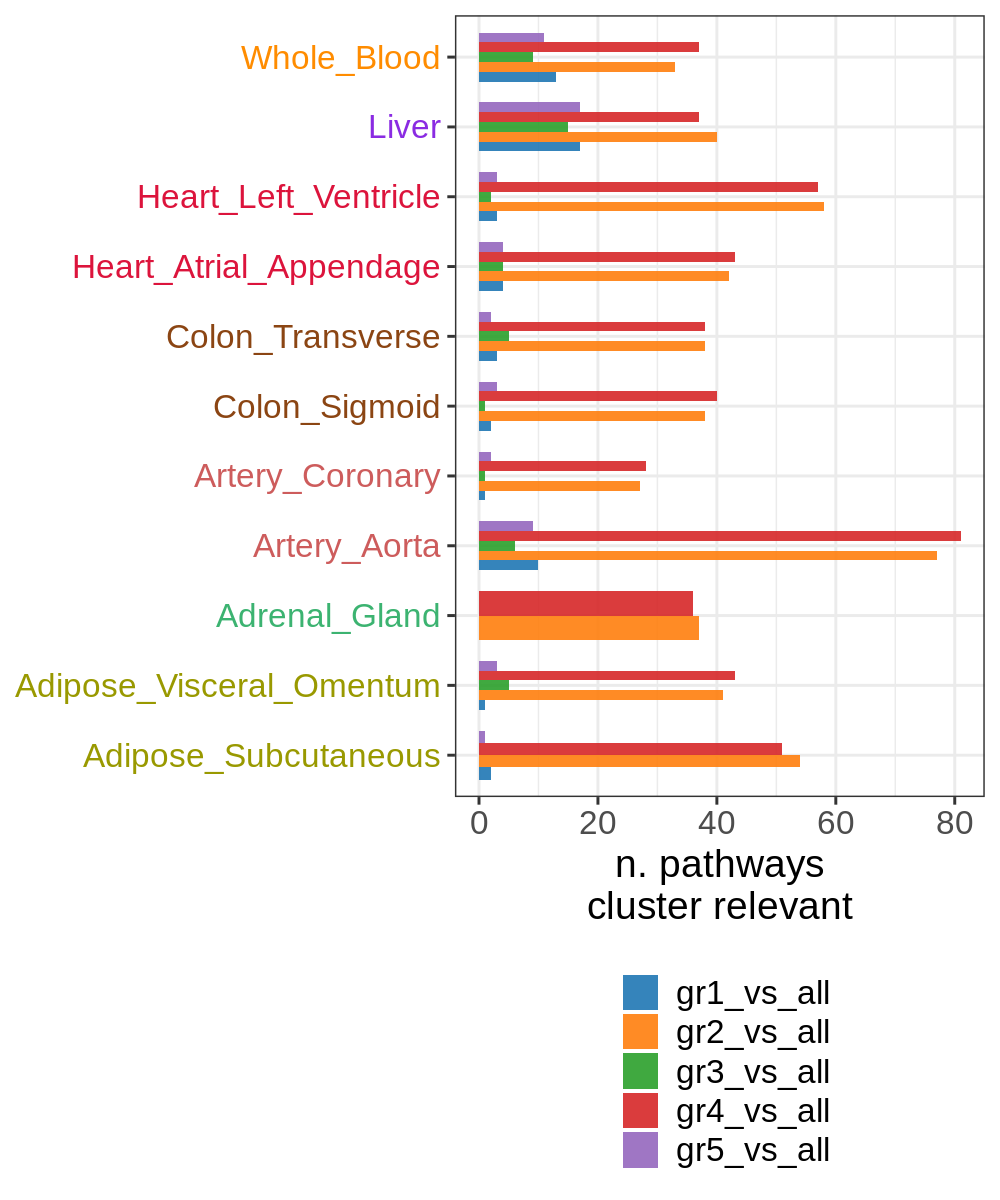

In [23]:
### plot count significant pathways ###
options(repr.plot.width = 5, repr.plot.height = 6, repr.plot.res = 200)

tmp <- path_gr_res %>% 
    mutate(tissue = factor(tissue, levels = tissues_name), 
           comp = factor(comp, levels = paste0(gr_tot, '_vs_all')))
df <- tmp %>% group_by(tissue, comp) %>% tally()
newcolours <-  color_tissues$color[match(tissues_name, color_tissues$tissues)]
color_gr <- pal_d3("category10")(length(gr_tot))
table(path_gr_res$tissue)

pl <- ggplot(data = df, aes(x = tissue, y = n, fill = comp))+
  geom_bar(alpha = 0.9, width = 0.7, stat = 'identity', position = position_dodge())+
  ylab('n. pathways\ncluster relevant')+ 
  theme_bw()+ 
  theme(legend.position = 'bottom', legend.key.size = unit(0.5, "cm"), 
        legend.text = element_text(size = 12), legend.title = element_blank(), 
        axis.title.y = element_blank(),  axis.title.x = element_text(size = 14), 
        axis.text.y = element_text(colour = newcolours, size = 12), 
        axis.text.x = element_text(size = 12))+
  guides(fill=guide_legend(nrow=5))+
  scale_fill_manual(values = color_gr)+
  # scale_fill_d3()+
  coord_flip() 
pl

ggsave(filename = sprintf('%scluster_npathways_alltissues_%s_%s.pdf', outFold, type_data, type_input), 
       plot = pl, width = 5, height = 6, dpi = 200)


In [25]:
### function to get improvement of pathways from genes ###
get_improvement <- function(pathway_test, tscore_test, gr, t, pathway_struct){
    
    tmp_path <- pathway_test %>% 
    filter(comp %in% gr, tissue %in% t) %>%
    mutate(db = pathway_struct$name[match(feat,pathway_struct$path)], 
           genes = pathway_struct$gene_name[match(feat,pathway_struct$path)], 
           pval_genes = NA, estimates_genes = NA, improvement = NA) %>%
    filter(!is.na(genes))
    
    tmp_tscore <- tscore_test %>% filter(comp %in% gr, tissue %in% t)
    if(nrow(tmp_path)>0){
    for(i in 1:nrow(tmp_path)){

        genes <- strsplit(tmp_path$genes[i], split = ',')[[1]]
        filt_genes <- tmp_tscore[match(genes, tmp_tscore$feat),]
        tmp_path$improvement[i] <- all(tmp_path$pval[i] < filt_genes$pval) 
        tmp_path$pval_genes[i] <- paste0(filt_genes$pval, collapse = ',') 
        tmp_path$estimates_genes[i] <- paste0(round(filt_genes$estimates, digits = 5), collapse = ',') 
        tmp_path$diff_pval_bestgene[i] <- tmp_path$pval[i] - min(filt_genes$pval)
    }
    }
    
    return(tmp_path)

}


In [26]:
gr_tot <- paste0('gr', sort(unique(clust_res$cl_best$gr)))
pathway_test <- path_gr_res
tscore_test <-  do.call(rbind, tscore_feat$test_feat)

path_anno <- list()
for(idg in 1:length(gr_tot)){

    gr <- paste0(gr_tot[idg], '_vs_all')
    print(gr)
    tmp <- list()
    for(idt in 1:length(tissues_name)){
        t <- tissues_name[idt]
        pathway_struct <- read.table(sprintf('OUTPUT_GTEx/predict_CAD/%s/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/selected_pathways_JSthr0.2.txt', t), h=T, stringsAsFactors = F)
        tmp[[idt]] <- get_improvement(path_gr_res, tscore_test, gr, t, pathway_struct)
    }
    path_anno[[idg]] <- do.call(rbind, tmp)
}
path_anno <- do.call(rbind, path_anno)

[1] "gr1_vs_all"
[1] "gr2_vs_all"
[1] "gr3_vs_all"
[1] "gr4_vs_all"
[1] "gr5_vs_all"


In [27]:
table(path_anno$pval_corr <= 0.01, path_anno$improvement)
a=path_anno[path_anno$pval_corr <= 0.01 & path_anno$improvement,]
table(a$comp)
a

      
       FALSE TRUE
  TRUE  1096   39


gr1_vs_all gr2_vs_all gr3_vs_all gr4_vs_all gr5_vs_all 
         1         17          1         19          1 

,feat,comp,pval,estimates,CI_low,CI_up,pval_corr,pval_corr_overall,tissue,db,genes,pval_genes,estimates_genes,improvement,diff_pval_bestgene
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
18,N-acetyltransferase activity,gr1_vs_all,5.01e-05,0.06467515,0.03339780,0.09583066,8.003475e-03,1.798534e-03,Colon_Transverse,GO,"ELP3,NAT10,SAT2,NAGS","0.119,0.0114,0.000293,0.146","0.00736,0.02731,0.01889,0.00751",TRUE,-2.429000e-04
192,Post-translational protein phosphorylation,gr2_vs_all,8.18e-12,0.11552103,0.08237622,0.14851256,1.944454e-10,4.204225e-10,Artery_Aorta,Reactome,"SERPINC1,QSOX1,MATN3,AFP,SPARCL1,DMP1,C4A,IGFBP3,LAMB1,PRSS23,HSP90B1,DNAJC3,MBTPS1","0.395,0.991,0.161,0.236,1,0.422,1.17e-08,0.603,0.96,0.527,0.672,0.334,0.46","-0.00108,-5e-05,-0.00653,-0.00473,-1e-05,-0.01393,0.01785,-0.00212,0.00088,0.0058,-0.00735,0.00151,0.01275",TRUE,-1.169182e-08
201,endopeptidase inhibitor activity,gr2_vs_all,5.01e-16,0.13738152,0.10417476,0.17048386,1.361050e-14,3.247960e-14,Artery_Aorta,GO,"GPX1,CAST,C4A,CD109,C5,USP14,CPAMD8,SPINT2,PSMF1,CSTB","0.209,0.269,1.17e-08,0.643,0.395,0.481,0.492,0.944,0.21,0.628","0.00467,-0.01866,0.01785,-0.00404,0.01131,-0.01099,-0.00265,0.00035,0.01146,-0.00823",TRUE,-1.170000e-08
235,regulation of complement activation,gr2_vs_all,9.95e-49,0.24366992,0.21116959,0.27605204,8.109250e-47,1.773898e-46,Artery_Aorta,GO,"CD46,C4A,C5,CD59","0.713,1.17e-08,0.395,0.439","0.00316,0.01785,0.01131,0.01176",TRUE,-1.170000e-08
281,antigen processing and presentation of endogenous peptide antigen via MHC class I,gr2_vs_all,9.26e-23,-0.16986187,-0.20364767,-0.13598424,3.404831e-21,9.221417e-21,Artery_Coronary,GO,"ERAP1,ERAP2,TAP2,TAPBP","0.00485,0.144,6.19e-20,6.96e-07","-0.04412,0.00496,-0.01743,-0.06285",TRUE,-6.180740e-20
290,negative regulation of neuron differentiation,gr2_vs_all,5.75e-04,0.05971304,0.02571208,0.09367665,9.477586e-03,2.114231e-02,Artery_Coronary,GO,"DTX1,NOTCH3,TTC3","0.000609,0.657,0.00678","0.01781,0.00756,0.0439",TRUE,-3.400000e-05
295,mRNA decay by 3' to 5' exoribonuclease,gr2_vs_all,4.48e-07,0.08720535,0.05333523,0.12091658,7.091200e-06,1.495133e-05,Colon_Sigmoid,Reactome,"SKIV2L,WDR61,EXOSC6,NT5C3B","6.52e-06,0.882,0.727,0.727","0.02994,-0.00253,0.00054,-0.00132",TRUE,-6.072000e-06
329,regulation of ERK1 and ERK2 cascade,gr2_vs_all,7.11e-04,0.05490423,0.02309610,0.08695061,8.562913e-03,1.840626e-02,Colon_Sigmoid,GO,"EPHB1,APIP,GSTP1","0.0483,0.0694,0.0896","0.00309,0.01877,0.01424",TRUE,-4.758900e-02
331,Complement cascade,gr2_vs_all,9.21e-17,0.13914415,0.10640386,0.17194051,2.802471e-15,6.396946e-15,Colon_Transverse,Reactome,"CFHR3,COLEC11,CPN2,C4A,CD59,IGHV1-69,IGHV2-70,IGLV4-60","0.0929,0.339,0.981,4.35e-10,0.625,0.903,0.937,0.749","-0.01396,-0.00073,-0.00015,0.04604,0.00835,-0.00024,-0.00054,-9e-04",TRUE,-4.349999e-10


Among the 1135 significant results, 39 have higher level of significance in pathways than genes

In [28]:
# get pathway sign and create matrix
path_unique <- unique(path_anno$feat)
N_path <- length(unique(path_anno$feat))

feat_est <- matrix(NA, nrow = N_path, ncol = length(gr_tot))
feat_CIl <- matrix(NA, nrow = N_path, ncol = length(gr_tot))
feat_CIu <- matrix(NA, nrow = N_path, ncol = length(gr_tot))
feat_pvcorr <- matrix(NA, nrow = N_path ,ncol = length(gr_tot))
new_name <- vector(mode = 'numeric', length = N_path)


for(i in 1:N_path){
# i=269
path <- path_unique[i]
tmp <- tot %>% filter(feat %in% path)
tmp <- tmp %>% filter(pval_corr <= 0.01)
top_t <- tmp[order(tmp$pval), ]
top_t <- tmp[order(abs(tmp$estimates), decreasing = T),]

t <- top_t$tissue[1]
short <- get_short_name(t)
new_name[i] <- paste(path, short)

feat_est[i,] <- tot$estimates[tot$tissue == t & tot$feat == path]
feat_CIl[i,] <- tot$CI_low[tot$tissue == t & tot$feat == path]
feat_CIu[i,] <- tot$CI_up[tot$tissue == t & tot$feat == path]
feat_pvcorr[i,] <- tot$pval_corr[tot$tissue == t & tot$feat == path]

}

rownames(feat_est) <- rownames(feat_CIl) <- rownames(feat_CIu) <- rownames(feat_pvcorr) <- new_name
colnames(feat_est) <- colnames(feat_CIl) <- colnames(feat_CIu) <- colnames(feat_pvcorr) <- gr_tot

res_pval_path <- do.call(rbind, pathway_feat$res_pval) 
res_pval_path <- left_join(res_pval_path, df_match) %>%
    mutate(new_id = paste(path, short))
res_pval_est <- res_pval_path[match(new_name, res_pval_path$new_id), ]


Joining, by = "tissue"



In [29]:
# create summary table and save

tmp <- path_anno %>% mutate(new_id = paste0(feat, '_', tissue))
unique_feat <- unique(tmp$new_id)
df <- data.frame(pathway = rep(NA,length(unique_feat)) , collection = rep(NA,length(unique_feat)), 
                 tissue= rep(NA,length(unique_feat)),  genes= rep(NA,length(unique_feat)), 
                 improvement_g = rep(NA,length(unique_feat)),
                 Zstat= rep(NA,length(unique_feat)), 
                 comp_sign= rep(NA,length(unique_feat)), 
                 WMW_est= rep(NA,length(unique_feat)), WMW_pvalue= rep(NA,length(unique_feat)))
for(i in 1:length(unique_feat)){
    
    tmp_i <- tmp %>% filter(new_id == unique_feat[i])
    df$pathway[i] <- tmp_i$feat[1]
    df$collection[i] <- tmp_i$db[1]
    df$tissue[i] <- tmp_i$tissue[1]
    df$genes[i] <- tmp_i$genes[1]
    df$improvement_g[i] <- paste0(tmp_i$improvement, collapse =  ',')
    df$Zstat[i] <- res_pval_path$CAD_HARD_z_t[res_pval_path$path == tmp_i$feat[1] & 
                                              res_pval_path$tissue ==  tmp_i$tissue[1]]
    df$comp_sign[i] <- paste0(sapply(tmp_i$comp, function(x) strsplit(x, split = '_vs_all')[[1]]), collapse =  ',')
    df$WMW_est[i] <- paste0(round(tmp_i$estimates, 4), collapse =  ',')
    df$WMW_pvalue[i] <- paste0(tmp_i$pval, collapse =  ',')
    
}

write.table(df, file = 'OUTPUT_GTEx/predict_CAD/Liver//200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/pathOriginal_filtJS0.2_corrPCs_tscoreClusterCases_summary.txt', 
           quote = F, sep = '\t', col.names = T, row.names = F)
                                     

In [30]:
df

pathway,collection,tissue,genes,improvement_g,Zstat,comp_sign,WMW_est,WMW_pvalue
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
axonal fasciculation,GO,Adipose_Subcutaneous,"AMIGO1,CNTN2,RTN4,CELSR3","FALSE,FALSE,FALSE",-0.22098505,"gr1,gr2,gr5","0.0953,-0.0642,0.1811","2.6e-09,0.000202,1.22e-06"
myelination,GO,Adipose_Subcutaneous,"AMIGO1,GNPAT,MPDZ,SBF2,EIF2B2,MYO5A,HEXA,PLLP,PMP22","FALSE,FALSE",0.04340641,"gr1,gr4","0.09,-0.0725","1.5e-08,3.18e-05"
response to estrogen,GO,Adipose_Visceral_Omentum,"GSTM3,DTYMK,GHRL,CRIPAK,ARSA","FALSE,FALSE,FALSE",0.17123957,"gr1,gr4,gr5","0.0944,-0.0645,0.155","2.15e-09,0.000196,3.65e-05"
cellular calcium ion homeostasis,GO,Artery_Aorta,"SYPL2,HTR2B,STIM2,EPHX2,C5,ITGB1,TPCN2,SLC37A4,TRPV4,HTR2A,PSEN1,CHRNA7,PRKCB,CCL5,PRKCA,CD40,VAPB","FALSE,FALSE,FALSE,FALSE",2.27916513,"gr1,gr2,gr3,gr5","-0.1172,0.0708,0.0863,-0.2124","1.61e-13,3.38e-05,3.14e-05,3.54e-08"
heterophilic cell-cell adhesion via plasma membrane cell adhesion molecules,GO,Artery_Aorta,"AMIGO1,AMICA1,AMIGO2,CD209","FALSE,FALSE",-0.63942826,"gr1,gr5","0.0887,0.2068","3.05e-08,2.2e-08"
axonogenesis,GO,Artery_Aorta,"DOCK7,NTNG1,AMIGO1,TBCE,GSK3B,UCHL1,MAP1B,FLOT1,DST,FZD1,FGFR2,PAK1,ATP8A2,POU4F1,LLGL1,ULK2,MAPT","FALSE,FALSE",-0.47693063,"gr1,gr2","0.073,-0.181","4.01e-06,7.72e-27"
axonal fasciculation,GO,Artery_Aorta,"AMIGO1,CNTN2,RTN4","FALSE,FALSE,FALSE,FALSE",-0.04619756,"gr1,gr2,gr4,gr5","0.1277,-0.0735,-0.0869,0.2552","1.47e-15,2.2e-05,9.39e-07,5.97e-12"
synaptic vesicle,GO,Artery_Aorta,"PPT1,SYPL2,MFF,SNCA,KIF3A,AMPH,SLC2A8,MTMR2,TRAPPC4,STON2,GRIN2A,RABAC1,SYNGR1","FALSE,FALSE,FALSE,FALSE,FALSE",-0.34297361,"gr1,gr2,gr3,gr4,gr5","-0.1642,0.0897,0.1033,0.087,-0.2776","8e-25,1.32e-07,5.89e-07,3.93e-07,8.22e-13"
Wnt signaling pathway,GO,Artery_Aorta,"CELSR2,LGR6,TCF7L1,LRRFIP2,ARL6,GSK3B,NPHP3,DVL3,TCF7,SFRP4,FZD1,WISP1,INVS,TNKS2,TCF7L2,DKK3,CD44,LRP5,TGFB1I1,WWOX,NXN,HIC1,SOST,WNT3,RNF138,CSNK1G2,RSPO4,KREMEN1","FALSE,FALSE,FALSE",-0.07766294,"gr1,gr4,gr5","-0.1178,0.0762,-0.2186","1.67e-13,1.19e-05,5.49e-09"


[1] 269   5

png 
  2

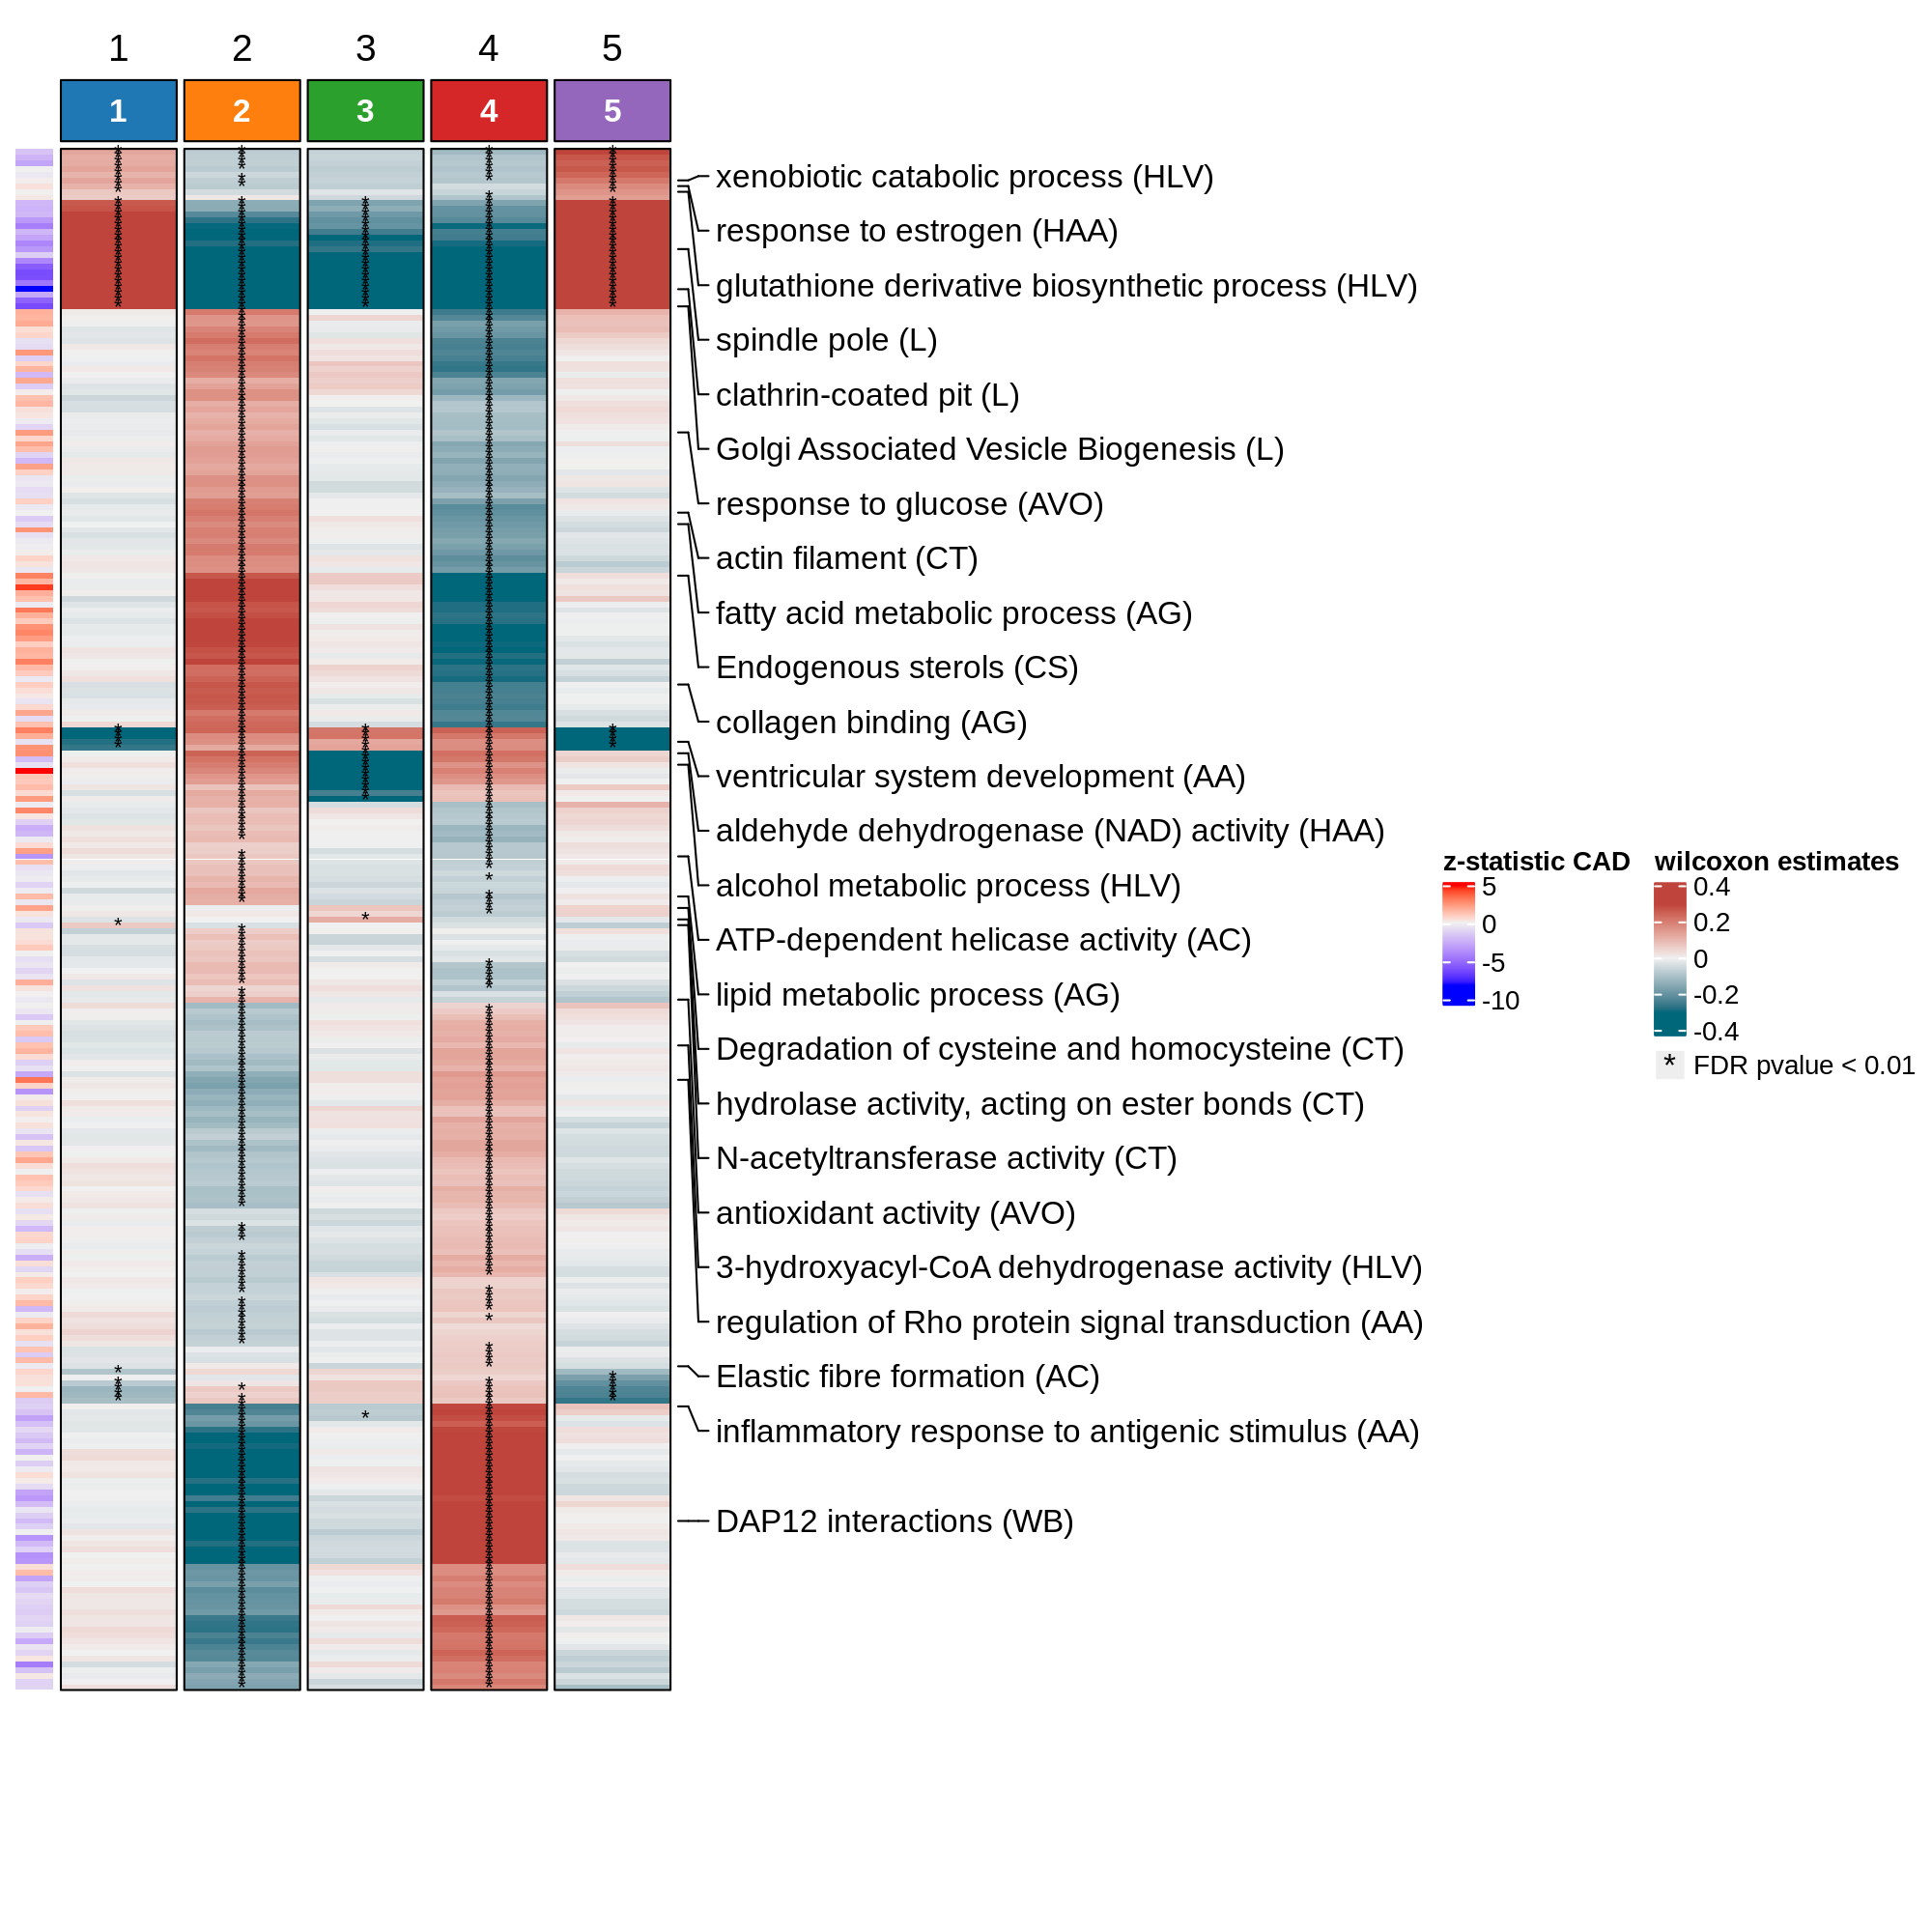

In [65]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)

pheno_name <- 'CAD'
def_mar = 30

show_path <- read.delim('OUTPUT_GTEx/predict_CAD/Liver//200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/show_path.txt', h=F, stringsAsFactors = F)
show_path <- show_path$V1
#show_path = 'clathrin-coated pit'
id <- which(res_pval_est$path %in% show_path)

P <- length(gr_tot)
# cap
tmp_mat <- as.matrix(feat_est)
dim(tmp_mat)
val <- abs(quantile(as.vector(feat_est),probs = 0.95))
mat_breaks <- seq(-val, val, length.out = 100)
tmp_mat[tmp_mat>=val] <- val
tmp_mat[tmp_mat<=-val] <- -val

mat_colors_gr <- list(cluster = pal_d3(palette = 'category20')(P))
names(mat_colors_gr$cluster) <- gr_tot

column_ha <- HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = mat_colors_gr$cluster),
                                                    labels = names(mat_colors_gr$cluster),
                                                    labels_gp = gpar(col = "white", fontsize = 12,  
                                                                     fontface = "bold")))
feat_pvcorr_pch <- feat_pvcorr
feat_pvcorr_pch[feat_pvcorr <= pval_corr_thr] <- '*'
feat_pvcorr_pch[feat_pvcorr > pval_corr_thr] <- ''

estimate_col_fun = colorRamp2(c(min(tmp_mat), 0, max(tmp_mat)), 
                                c("#00677B", "#F0F0F0", "#BF443B"))
zstat_col_fun = colorRamp2(c(min(res_pval_est[,12]), 0, max(res_pval_est[,12])), 
                             c("blue","#F0F0F0", "red"))

row_ha <- rowAnnotation(zstat = res_pval_est[,12],
                        col = list(zstat = zstat_col_fun), 
                        annotation_label = list(zstat = sprintf('z-statistic %s', pheno_name)), 
                        annotation_name_gp = gpar(col = 'white'))

row_ha_names <- rowAnnotation(foo = anno_mark(at = id, 
                                              labels = res_pval_est$new_id[id])) 
                             

lgd_est <- Legend(title = "wilcoxon estimates", col = estimate_col_fun)
lgd_sig = Legend(pch = "*", type = "points", labels = sprintf("FDR pvalue < %s", as.character(pval_corr_thr)))

hm_pl <- Heatmap(tmp_mat, top_annotation = column_ha, 
                 left_annotation = row_ha,  
                 right_annotation = row_ha_names, 
                 #row_km = 9,
                 column_split = gr_tot, 
                 cluster_rows = T, cluster_columns = F, 
                 show_column_names = F, show_row_names = F, 
                 show_row_dend=F, 
                 col = estimate_col_fun, border = TRUE, show_heatmap_legend = F, 
                 cell_fun = function(j, i, x, y, width, height, fill){
                           grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y, gp = gpar(fontsize = 8))})

side_par <- round(max(sapply(rownames(tmp_mat), nchar))) + 30
pdf(sprintf('%sheatmap_cluster_pathway_WMWest_%s_%s.pdf', outFold, type_data, type_input), width= 10, height = 8)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) #padding = unit(c(2,def_mar + side_par , 2, 2), "mm"))
dev.off() 
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) 
#    padding = unit(c(2, def_mar + side_par, 2, 2), "mm"))

In [32]:
# get info
geneInfo <- list()
for(idt in 1:length(tissues_name)){
    t <- tissues_name[idt]
    tmp <- fread(geneInfo_file[idt], data.table = F, h=T, stringsAsFactors = F)
    tmp$short <- df_match$short[df_match$tissue == t]
    tmp$new_id <- paste(tmp$external_gene_name, df_match$short[df_match$tissue == t])
    geneInfo[[idt]] <- tmp
}
geneInfo <- do.call(rbind, geneInfo)
geneInfo <- geneInfo[match(tscore_tot$new_id, geneInfo$new_id),]

length(unique(tscore_tot$new_id))
length(unique(tscore_tot$feat))
nrow(loci_tissues)
nrow(loci_all)

#geneInfo[geneInfo$new_id %in% c('ELP3 (CT)','NAT10 (CT)','SAT2 (CT)','NAGS (CT)'),]

[1] 36397

[1] 13387

[1] 44

[1] 11


   Cases Controls 
   19023   321916 


 gr1  gr2  gr3  gr4  gr5 
6105 4783 2831 4520  784 

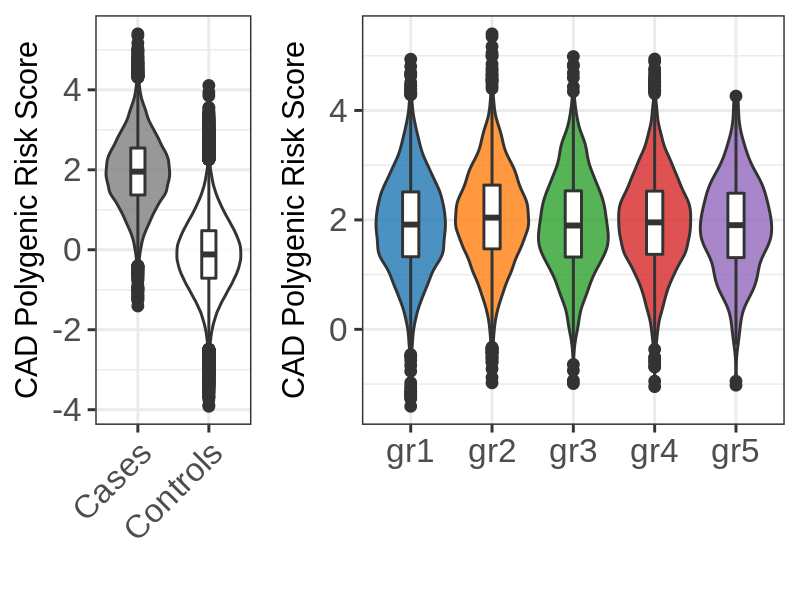

In [8]:
### load PRS and check distribution across groups
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 200)

PRS_res <- read.table("OUTPUT_GWAS/PRS/PRS_CAD_UKBB.best", h=T, stringsAsFactors = F)
PRS_res$PRS_scaled <- scale(PRS_res$PRS)

cl_res <- clust_res$cl_best
gr_tot <- unique(cl_res$gr)
color_gr <- pal_d3("category10")(length(gr_tot))

PRS_res$id <- paste0("X", PRS_res$FID)
PRS_res$type <- "Controls"
PRS_res$type[PRS_res$id %in% cl_res$id] <- "Cases"


PRS_cases <- PRS_res[match(cl_res$id, PRS_res$id),]
PRS_cases$gr <- paste0("gr",cl_res$gr)

pl_cases <- ggplot(data = PRS_cases, aes(x = gr, y = PRS_scaled, fill = gr)) + 
    geom_violin(alpha = 0.8)+
    geom_boxplot(width=0.2, fill="white")+
    theme_bw() + 
    theme(legend.position = "none", axis.text = element_text(size = 12)) +
    xlab("") + 
    ylab("CAD Polygenic Risk Score") + 
    scale_fill_manual(values = color_gr)

pl <- ggplot(data = PRS_res, aes(x = type, y = PRS_scaled, fill = type)) + 
    geom_violin(alpha = 0.8)+
    geom_boxplot(width=0.2, fill="white")+
    theme_bw() + 
    theme(legend.position = "none", 
          axis.text = element_text(size = 12), 
          axis.text.x = element_text(angle = 45, hjust = 1)) +
    xlab("") + 
    ylab("CAD Polygenic Risk Score") + 
    scale_fill_manual(values = c("grey50", "white"))

tot_pl <- ggarrange(plotlist = list(pl, pl_cases), nrow = 1,align = "hv", widths = c(0.5, 1))
tot_pl

ggsave(plot = tot_pl, filename = sprintf('%scl%s_PRS_distribution.pdf',  outFold, 'Liver'), 
       device = 'pdf', width = 4, height = 3)

table(PRS_res$type)
table(PRS_cases$gr)

